# 6. Inverse theory methods

In [103]:
%plot --format svg -s 800,600
octave_app_diagnostic_dump

error: 'octave_app_diagnostic_dump' undefined near line 1, column 1


## 6.1 Review of the least-squares fitting

Linear regression that we used for the last project, was essentially a problem of minimizing the following sum of squares of residuals, i.e. the differences between the data $(x_i,y_i)$ and the linear model $y(x)=c_0+c_1 x$ predictions:
$$
 \min \left[ \sum_{i=1}^m r_i^2 \right] , \quad r_i = y_i - (c_0 + c_1 x_i)
$$
In matrix form, the problem is to solve the set of linear equations
$$
  \vec{y} = \left( \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_m\end{array} \right) =
  \left( \begin{array}{cc} 1 & x_1 \\ 1 & x_2 \\ \vdots & \dots \\ 1 & x_m\end{array} \right)
  \left( \begin{array}{c} c_0 \\ c_1 \end{array} \right)
$$
for $\{ c_0,c_1\}$.  In <code>octave</code> this can be accomplished by using operator <code> \ </code>:

c =

  -0.5533
   0.9897



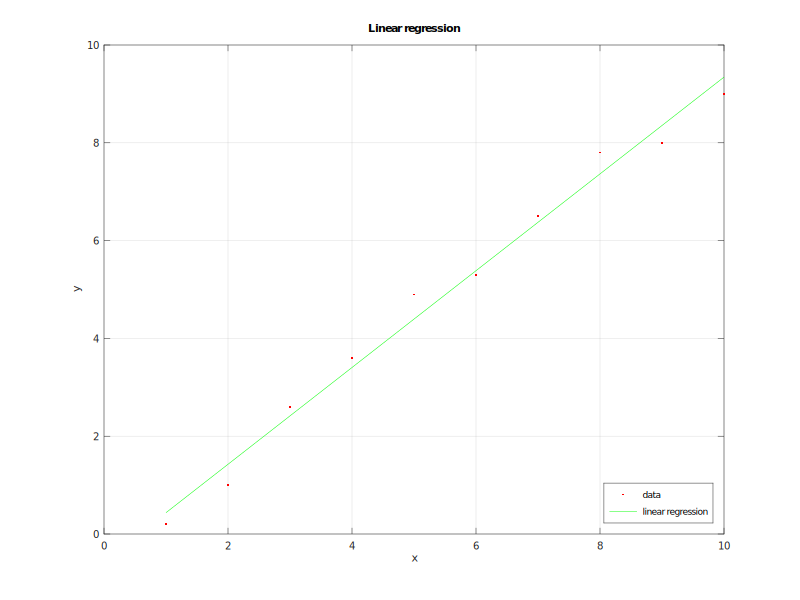

In [104]:
x_data = [1:10]';
y_data = [ 0.2 1.0 2.6 3.6 4.9 5.3 6.5 7.8 8.0 9.0 ]';
A = [ ones(size(x_data)) x_data ];
c = A \ y_data

y_lr = A*c;
plot(x_data,y_data,'r.;data;',
     x_data,y_lr,'g-;linear regression;');
ylabel('y');
xlabel('x');
legend("location",'southeast');
box on;
grid on;
title('Linear regression');

There is another way to look at the solution of this <i>over</i>determined problem
$$
  \vec{y} = {A} \vec{c}
$$
Any full rank matrix $A ∈ R^{m×n}$ , with $m \geq n$, admits a unique $QR$ factorization
$A = QR$. It is possible to prove that $A = \tilde{Q}\tilde{R}$ where $\tilde{Q}=Q(1:m.1:n)$ and $\tilde{R}=R(1:n,1:n)$ are the submatrices as showni below (figure from A.Quarteroni, F.Saleri and P.Gervasio, <i>Scientific Computing with
MATLAB and Octave</i>, 3rd ed, Springer).
<p>
<img src="QRfactorization.png" alt="[Fig5.9]">
<p>
$\tilde{Q}$ has orthonormal column vectors, while $\tilde{R}$ is a non-singular upper triangular matrix. Therefore, the unique solution is given by
$$
  \vec{c}^* = (\tilde{R})^{-1} (\tilde{Q})^T \vec{y}
$$

In [105]:
### another view of the same linear regression problem: QR factorization
### Again, solving A c = y for c by using A=QR
[m,n] = size(A);
### only works for an OVERdetermined system, m>n (here m=10, n=2)
[Q,R] = qr(A);
## \tilde{Q} is an (mxn) subset of Q(mxm), \tilde{R} is an (nxn) subset of R(mxn)
Qt = Q(:,1:n); Rt = R(1:n,:);
## \tilde{Q} is an orthogonal matrix, so Qt`*Qt should be an identity:
Qt'*Qt
## R is already an upper-triungular matrix, so this should be identically zero:
Rt - triu(Rt)
## and this yields exactly the same result as before
[c  (Rt \ (Qt'*y_data)) ]

ans =

   1.0000e+00  -5.8523e-17
  -5.8523e-17   1.0000e+00

ans =

   0   0
   0   0

ans =

  -0.5533  -0.5533
   0.9897   0.9897



But what if the task is not to minimize the (vertical) differences between $y_i$ and $c_0 + c_1 x_i$, but instead the sum of the <i>distances</i> between the data points and the line of fit?  Another formulation of the problem is the "minimum length of water pipes" of an example distributed with eXtrema, see https://www.physics.brocku.ca/Labs/extrema/.

On a plane, a straight line can be represented by the equation
$$
  c_0 + c_1 x + c_2 y = 0, \quad c_1^2 + c_2^2 = 1
$$
where $(c_1,c_2)$ is the unit vector perpendicular to the line.  For points $(x_i,y_i)$ <i>not</i> on the line, the above equation represents the distances of the points from the line,
$$
  r_i = c_0 + c_1 x_i + c_2 y_i 
$$
and the problem becomes the minimization of the total sum of such distances:
$$
  \min ||\vec{r} ||^2 = \min \left[ \sum_{i=1}^m r_i^2 \right]
$$
subject to
$$
  \vec{r} = \left( \begin{array}{c} r_1 \\ r_2 \\ \vdots \\ r_m\end{array} \right) =
  \left( \begin{array}{ccc} 1 & x_1 & y_1 \\ 1 & x_2 & y_2 \\ \vdots & \dots & \vdots\\ 1 & x_m & y_m\end{array} \right)
  \left( \begin{array}{c} c_0 \\ c_1 \\ c_2\end{array} \right)  = A \vec{c}
  \quad \mbox{and} \quad
  c_1^2+c_2^2=1
$$

Commands 
<a href="https://www.mathworks.com/help/matlab/ref/qr.html" target="_blank">qr()</a>, 
<a href="https://www.mathworks.com/help/matlab/ref/triu.html" target="_blank">triu()</a>, and
<a href="https://www.mathworks.com/help/matlab/ref/svd.html" target="_blank">svd()</a>
will come handy.

ans =

  -0.4162   0.7057  -0.7086   1.0000   1.0000   1.0000



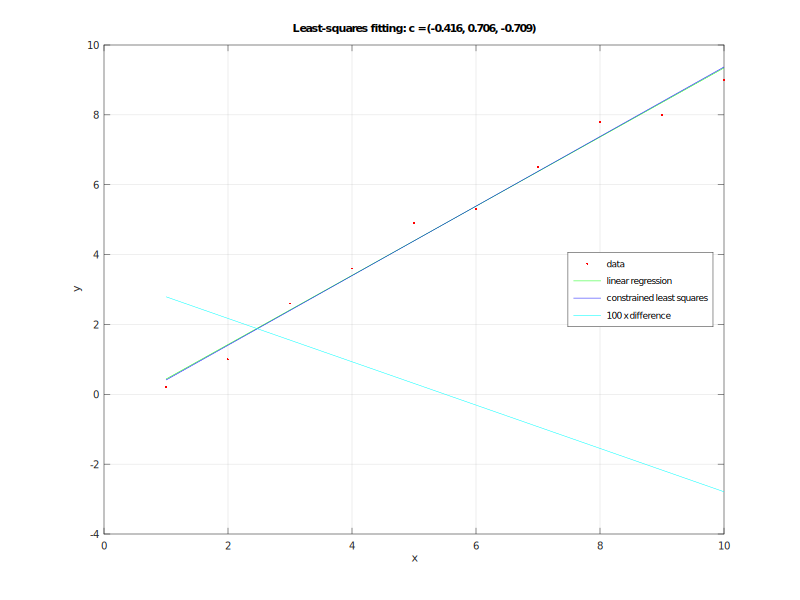

In [106]:
# this function solves the constrained least squares problem r = A c
A = [ ones(size(x_data)) x_data y_data ];
## m data, n parameters of the fit
[m,n] = size(A);
## on a two-dimensional plane, line normal only has two 
## components, (c_1,c_2), so only two parameters of the fit
dim = 2; 
if n < dim+1, error ('not enough parameters'); end;
if m < dim, error ('not enough data points'); end;

## QR factorization
[Q,R] = qr(A);
## Singular value decomposition: V^T S* U = pseudoinverse of A
[U,S,V] = svd(R(n-dim+1:m,n-dim+1:n)); 
cc = V(:,dim);  ## only dim constraints are involved
cc_0 = -R(1:n-dim,1:n-dim) \ (R(1:n-dim,n-dim+1:n)*cc);

[ [cc_0 cc'] (sqrt(cc(1)^2+cc(2)^2)) cc'*cc norm(cc)]

y_ls = -(cc_0+cc(1)*x_data)/cc(2);
plot(x_data,y_data,'r.;data;',
     x_data,y_lr,'g-;linear regression;',
     x_data,y_ls,'b-;constrained least squares;',
     x_data,100*(y_lr - y_ls),'c-;100 x difference;');
ylabel('y');
xlabel('x');
legend("location",'east');
box on;
grid on;
title(sprintf('Least-squares fitting: c = (%.3f, %.3f, %.3f)',cc_0,cc(1),cc(2)));

## 6.2 Introduction to inverse problems

In [107]:
%bash
ls /work/5P10/Inverse/

ls: /work/5P10/Inverse/: No such file or directory


<a href="http://www.physics.brocku.ca/Courses/5P10/Lectures/inverse-theory-methods.pdf">Inverse Theory presentation (pdf)</a>

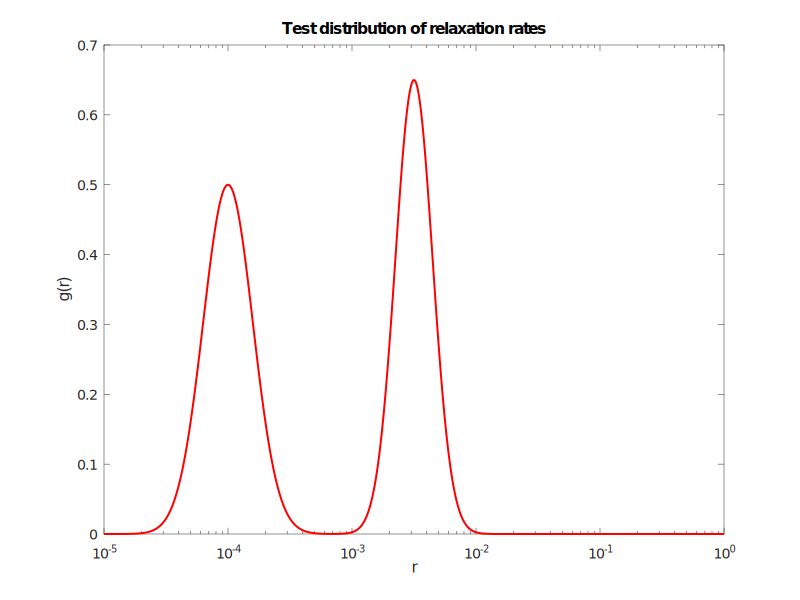

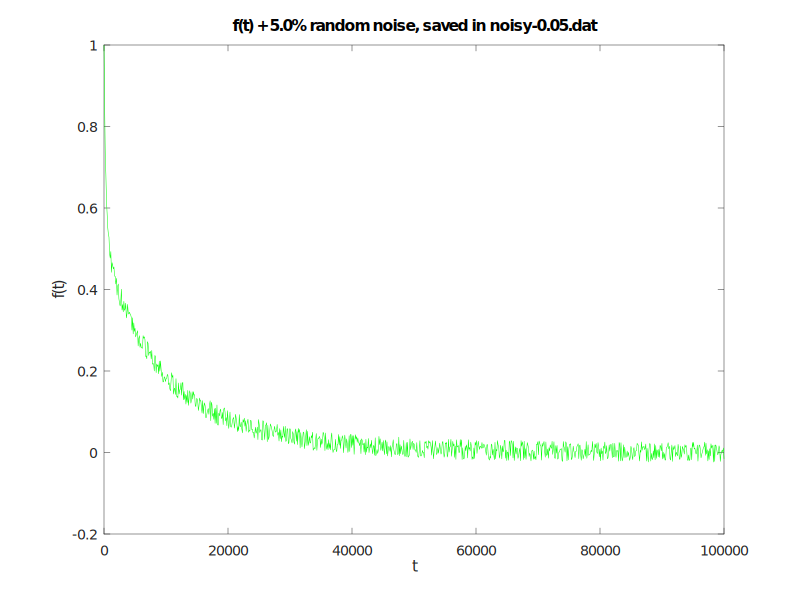

In [108]:
%%  expo_maketest.m
%    make f(t) + noise, for testing TR analysis of 
%    a distribution of relaxation rates, g(r) 
%
%  Completed: Dec.2005, Edward Sternin <edward dot sternin at brocku dot ca>
%  Contributions: Hartmut Schaefer
%  Revisions: 2018.02 ES converted to matlab/octave from SciLab
%
clear;

noise=0.05;     % noise as fraction of the max(f(t))
datafile=sprintf("noisy-%.2f.dat",noise);

t_steps=1000;   % t-domain signal has this many points,
t_min=1;        %  from this minimum,
t_max=1e5;      %  to this maximum
r_steps=500;    % r-grid has this many points,
r_min=1/t_max;  %  from this minimum,
r_max=1/t_min;  %  to this maximum

% Use an array of Gaussian peaks that make up the true g(r):
%peaks = [[0.5 0.20 0.04];[0.65 0.50 0.03];[0.75 0.80 0.03]];    % [amplitude center width]
peaks = [[0.5 0.20 0.04];[0.65 0.50 0.03]];   % [amplitude center width]
%peaks = [[0.6 0.35 0.1];[0.1 0.45 0.15]];    % [amplitude center width]

%  create a vector of r values, logarithmically spaced
r_scale = log(r_max)-log(r_min);
r = exp([log(r_min):r_scale/(r_steps-1):log(r_max)])'; % use a column vector

%  build up g(r) by adding Gaussian contributions from all peaks
g = zeros(length(r),1);
for k=1:length(peaks(:,1))
  r0 = log(r_min) +  r_scale*peaks(k,2);
  dr = r_scale*peaks(k,3);
  g += peaks(k,1) * exp (- (log(r) - r0).^2 / (2 * dr^2));
end

f1=figure(1); clf(1);
semilogx(r,g,'r-','LineWidth',2);
ylabel("g(r)");
xlabel("r");
title("Test distribution of relaxation rates");
FS = findall(f1,'-property','FontSize');
set(FS,'FontSize',14);
%print -dpng g.png

%  create a vector of t values, linearly spaced; use column vectors for f(t)
t = [t_min:(t_max-t_min)/(t_steps-1):t_max]';

%  generate time-domain data
f = (1/(length(t)-1)*g'*exp(-r*t'))';

%  normalize and add random noise
f /= max(f);
f += noise*(-0.5+rand(length(f),1));

f2=figure(2); clf(2);
plot(t,f,'g-');
%semilogy(t,f,'g-');
ylabel("f(t)");
xlabel("t");
title(sprintf("f(t) + %.1f%% random noise, saved in %s",100*noise,datafile));
FS = findall(f2,'-property','FontSize');
set(FS,'FontSize',14);
%print -dpng f.png

%system(sprintf("rm -rf %s",datafile));
f_of_t=[t f];
save("-ascii",datafile,"f_of_t");

g_of_r=[r g];
save("-ascii","true_g.dat","g_of_r");


error: =: nonconformant arguments (op1 is 1x1, op2 is 1000x1)


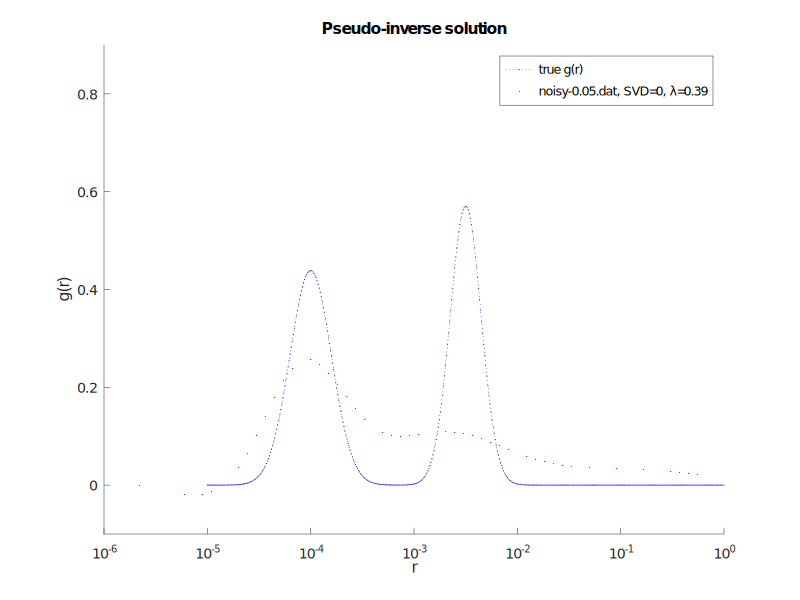

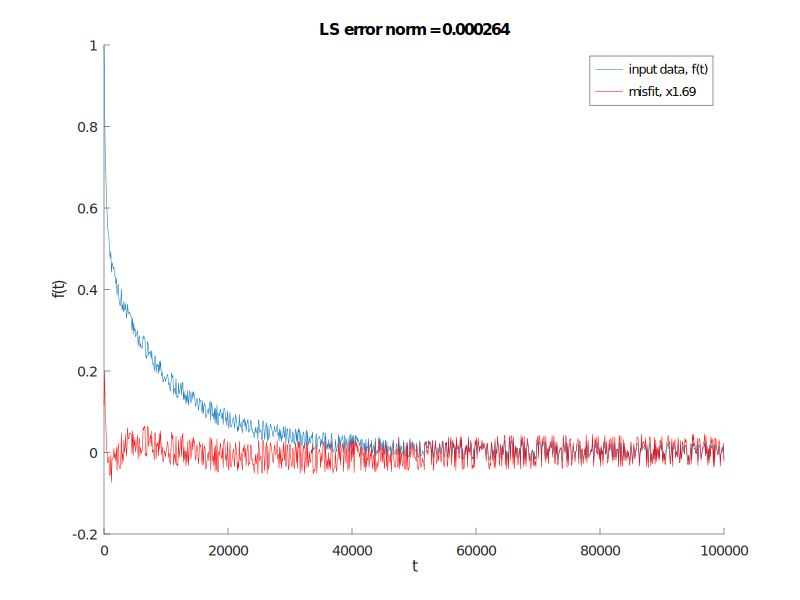

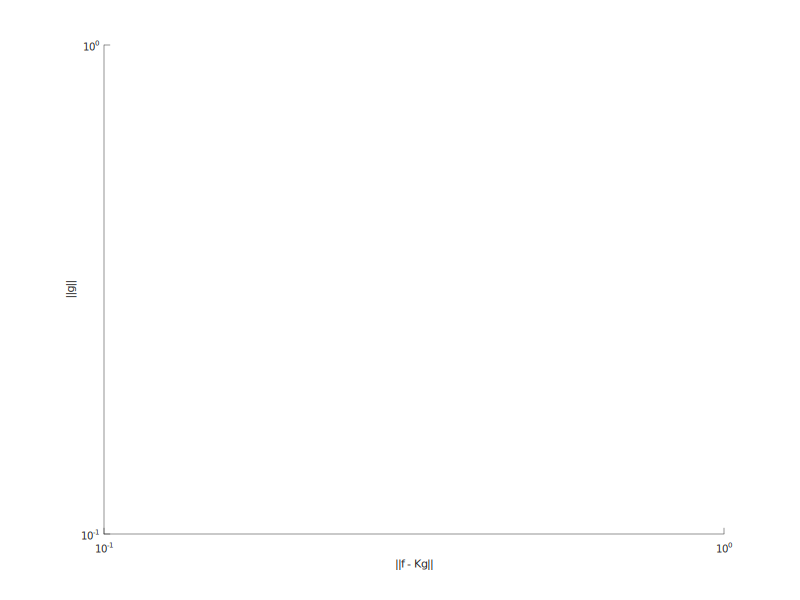

In [109]:
%% expo.m
%  multi-exponential inverse analysis of time decay curves
%    f(t) = \int g(r) exp(-r*t) dr
%
%  Notation:
%    r = vector or r values
%    n = number of points in r
%    g = vector of unknowns, g(r)
%    t = vector of t values
%    m = number of points in t
%    f = vector of measured data, f(t)
%    K = (m x n) kernel matrix
%    svd_cnt = keep only this many singular values
%    lambda = Tikhonov regularization parameter
%    datafile = (noisy) data, in two columns: (t,f)
%
%  Completed: Dec.2005, Edward Sternin <edward dot sternin at brocku dot ca>
%  Contributions: Hartmut Schaefer
%  Revisions: 2018.02 ES converted to matlab/octave from SciLab
%
pkg load control

clear;

function [g] = regularize(t,f,r,K,svd_n,lambda)
  m=length(f);
  n=length(r);
  if (m < n) 
    error ("This code is not meant for underdetermined problems, need more data");
  end

  %  SVD of the kernel matrix
  [U,S,V]=svd(K);

  nt=n;
  %  if requested, truncate the number of singular values
  if (svd_n > 0)
    nt=min(n,svd_n);
    nt=max(nt,2); % but not too few!
  end

  %  Tikhonov regularization
  sl=S(nt,nt);
  for k=1:nt 
    sl(k,k)=S(k,k)/(S(k,k)^2+lambda);
  end

  % return g(r)
  g=V(1:n,1:nt)*sl*U(1:m,1:nt)'*f;  
  
end

%====================================================

datafile='noisy-0.05.dat';
r_steps=70;  % r-grid has this many points,
r_min=1e-6;  % from this minimum,
r_max=1;     % to this maximum
svd_cnt=0;   % set to 0 for no SVD truncation`
lambda=3.85e-01; % set to 0 for no Tikhonov regularization

%  read in the time-domain data
f_of_t=dlmread(datafile);
t=f_of_t(:,1); % first column is time
f=f_of_t(:,2); % second column is f(t)

%  create a vector of r values, logarithmically spaced
r_inc = (log(r_max)-log(r_min)) / (r_steps-1);
r = exp([log(r_min):r_inc:log(r_max)]);

%  set up our kernel matrix, normalize by the step in r
K = exp(-t*r) * r_inc;

%  call the inversion routine
[g] = regularize(t,f,r,K,svd_cnt,lambda);

%  plot the original data f(t) and our misfit
f1=figure(1); clf(1);
hold on;
plot(t,f,'-'); 

misfit = f - K*g ;
Psi = sum(misfit.^2)/(length(f)-1);
scale=0.2*max(f)/max(misfit);
plot(t,scale*misfit,'-r');

title(sprintf("LS error norm = %f",Psi));
xlabel("t");
ylabel("f(t)");
legend("input data, f(t)",sprintf("misfit, x%.2f",scale));
FS = findall(f1,'-property','FontSize');
set(FS,'FontSize',14);
hold off;

%  separately, plot the result of the inversion
f2=figure(2); clf(2);
hold on;

g_of_r=dlmread("true_g.dat");
r_true=g_of_r(:,1);
g_true=g_of_r(:,2);
r_inc_true=(log(max(r_true))-log(min(r_true)))/(length(r_true)-1);
semilogx(r_true,g_true/(sum(g_true)*r_inc_true),'b:o','MarkerSize',0.5);

semilogx(r,g/(sum(g)*r_inc),'r.','MarkerSize',3);
title("Pseudo-inverse solution");
xlabel("r");
ylabel("g(r)");
legend("true g(r)",sprintf("%s, SVD=%d, \\lambda=%.2g",datafile,svd_cnt,lambda));
FS = findall(f2,'-property','FontSize');
set(FS,'FontSize',14);
ylim([-0.1 0.9])   % last-minute tweak, to avoid the legend
hold off;


f3=figure(3); clf(3);

hold on;

% Define the range
lower_bound = -1;
upper_bound = 1;

% Define the number of random values you want
num_values = 50;

% Generate random values within the specified range
lambda_list = lower_bound + (upper_bound - lower_bound) * rand(1, num_values);


% Initialize a list to store the values of xx and yy
xx = [];
yy = [];

% Assuming you have defined t, f, r, K, svd_cnt before this loop

for lambda = lambda_list
    % Call the inversion routine
    [g] = regularize(t,f,r,K,svd_cnt,lambda);
    
    % Store g in the list
    xx(end+1) = f - K*g;
    yy(end+1) = norm(g);
end

 % Plot the results
loglog(xx, yy);
ylabel('||g||');
xlabel('||f - Kg||');

hold off;

%print -depsc result.eps

corner = 1.6123
corner = 1.5540
corner = 1.4956
corner = 1.4360
corner = 1.3744
corner = 1.3103
corner = 1.2431
corner = 1.1725
corner = 1.0987
corner = 1.0217
corner = 0.9418
corner = 0.8597
corner = 0.7760
corner = 0.6913
corner = 0.6067
corner = 0.5228
corner = 0.4404
corner = 0.3602
corner = 0.2827
corner = 0.2083
corner = 0.1370
corner = 0.069006
corner = 4.2814e-03
corner = -0.057240
corner = -0.1156
corner = -0.1708
corner = -0.2229
corner = -0.2718
corner = -0.3173
corner = -0.3594
corner = -0.3979
corner = -0.4329
corner = -0.4643
corner = -0.4920
corner = -0.5163
corner = -0.5373
corner = -0.5553
corner = -0.5704
corner = -0.5830
corner = -0.5935
corner = -0.6022
corner = -0.6094
corner = -0.6153
corner = -0.6204
corner = -0.6248
corner = -0.6287
corner = -0.6323
corner = -0.6358
corner = -0.6394
corner = -0.6431
corner = -0.6470
corner = -0.6513
corner = -0.6560
corner = -0.6612
corner = -0.6669
corner = -0.6733
corner = -0.6803
corner = -0.6880
corner = -0.6963
corner = -0.

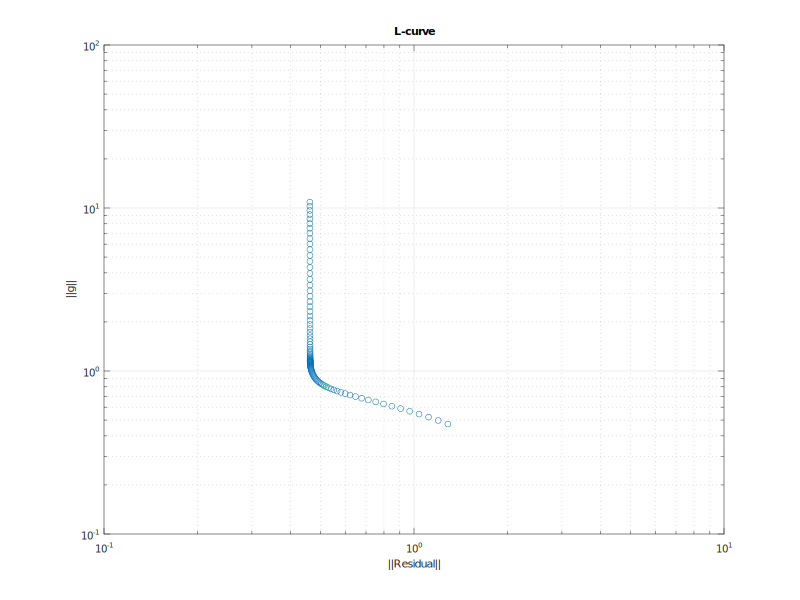

In [110]:
pkg load matgeom

datafile = 'noisy-0.05.dat';
r_steps = 70;
r_min = 1e-6;
r_max = 1;
svd_cnt = 0;

% Read in the time-domain data
f_of_t = dlmread(datafile);
t = f_of_t(:, 1);
f = f_of_t(:, 2);

r_inc = (log(r_max) - log(r_min)) / (r_steps - 1);
r = exp([log(r_min):r_inc:log(r_max)]);
K = exp(-t * r) * r_inc;

% Define a range of lambda values to test
lambda_values = logspace(-6, 1, 100); % Adjust the range as needed

% Initialize arrays to store norms
norm_g = zeros(size(lambda_values));
norm_residual = zeros(size(lambda_values));

temp = 0;
ind = 0;

for i = 1:length(lambda_values)
    lambda = lambda_values(i);
    [g] = regularize(t, f, r, K, svd_cnt, lambda);
    
    % Calculate norms
    norm_g(i) = norm(g);
    misfit = f - K * g;
    norm_residual(i) = norm(misfit);


    corner = log(norm_residual(i))+log(norm_g(i))

    if corner < temp
        ind = i;
        temp = corner;
    endif
end

% Plot the L-curve
figure;
loglog(norm_residual, norm_g, 'o', norm_residual(ind), norm_g(ind), 'go');
xlabel('||Residual||');
ylabel('||g||');
title('L-curve');
grid on;

fprintf('Index of the corner: %d\n', ind);
fprintf('Corresponding lambda: %.2e\n', lambda_values(ind));


## 6.3 Homework, due 2022-11-14

<ul>
<li> Review the concept of SVD decomposition.
<li> Analyze the skeleton code of regularize(); make sure you understand every line.
<li> Modify the main code by adding appropriate loops, etc. to reproduce the results
presented for the exponential example, including the L-curves, on the sample data
provided in /work/5P10/test.dat
<li> Automate the optimum selection of parameter λ. One possible approach is to seek the
value that corresponds to the shortest distance to the origin on the L-curve. Be efficient:
vary the step size in λ depending on how strong the dependence on λ is.
<li> Optionally, use your program to analyze a real experimental data set (in /work/5P10/Inverse/).
</ul>

<img src="http://www.physics.brocku.ca/Courses/5P10/Lectures/pmma.png" alt="[pmma.png]" width="800">

ans = 10


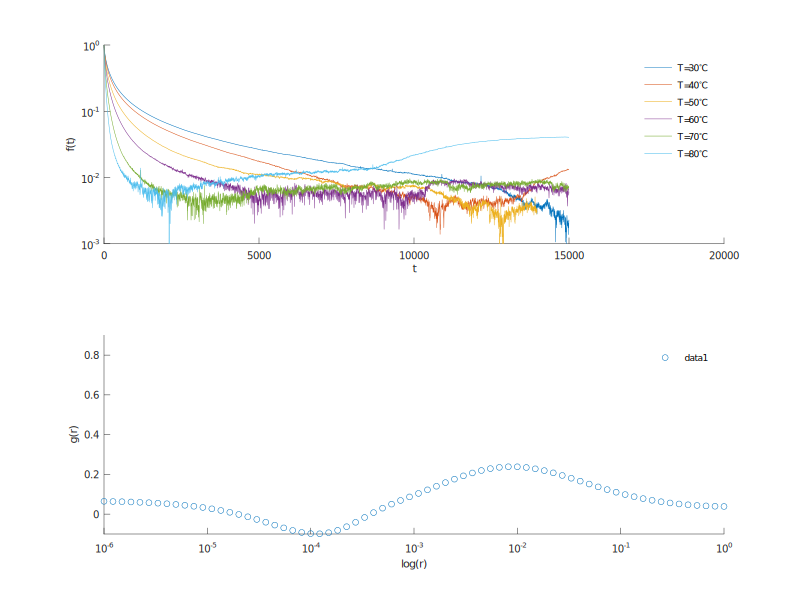

In [114]:
warning('off', 'all');

subplot(2,1,1);
hold on;

temp = [30:10:80];

for i = 1:length(temp)
    datafile = sprintf("%dC.dat", temp(i));
    f_of_t = dlmread(datafile);
    t = f_of_t(:,1); % first column is time
    f = f_of_t(:,2); % second column is f(t)
    f = f.*sign(f);
    semilogy(t, f, sprintf("-;T=%d^\\circC;", temp(i)));
end

legend("boxoff");
ylabel("f(t)");
xlabel("t");
ylim([10^(-3.0) 10^(0)]);

hold off;

r_steps=70;  % r-grid has this many points,
r_min=1e-6;  % from this minimum,
r_max=1;     % to this maximum
svd_cnt=0;   % set to 0 for no SVD truncation`
lambda=1e-4; % set to 0 for no Tikhonov regularization


subplot(2,1,2);
hold on;

temp = [80];
for i = 1:length(temp)
    datafile = sprintf("%dC.dat", temp(i));
    f_of_t = dlmread(datafile);
    t = f_of_t(:,1); % first column is time
    f = f_of_t(:,2); % second column is f(t)
    f = f.*sign(f);


    r_inc = (log(r_max)-log(r_min)) / (r_steps-1);
    r = exp([log(r_min):r_inc:log(r_max)]);
    K = exp(-t*r) * r_inc;

    [g] = regularize(t,f,r,K,svd_cnt,lambda);
    
    misfit = f - K*g ;
    Psi = sum(misfit.^2)/(length(f)-1);

    lambda_values = logspace(-6, 1, 100); % Adjust the range as needed

    % Initialize arrays to store norms
    norm_g = zeros(size(lambda_values));
    norm_residual = zeros(size(lambda_values));

    temps = 0;
    ind = 0;

    for i = 1:length(lambda_values)
        lambda = lambda_values(i);
        [g] = regularize(t, f, r, K, svd_cnt, lambda);
        
        % Calculate norms
        norm_g(i) = norm(g);
        misfit = f - K * g;
        norm_residual(i) = norm(misfit);


        corner = log(norm_residual(i))+log(norm_g(i));

        if corner < temp
            ind = i;
            temps = corner;
        endif
    end
    
    lambda_values(ind)

    [g] = regularize(t,f,r,K,svd_cnt,lambda_values(ind));

    semilogx(r, g/(sum(g)*r_inc), 'o');
    
end

legend("boxoff");
xlabel("log(r)");
ylabel("g(r)");
ylim([-0.1 0.9]);
   
hold off;

